# Sparkify-analysis and preprocessing
This notebooks contains the preliminary cleaning, data analyis and feature engineering for the Sparkify customer churn model development.

This precedes Sparkify-model build.ipynb

In [1]:
#Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, asc, desc, lit, min, max, udf, isnull,when, row_number, floor,ceil, sum ,count, countDistinct
from pyspark.sql.types import IntegerType,DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes, GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

import datetime
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from time import time

import gc

In [2]:
#Check versions of packages
from platform import python_version

print(python_version())

print(pd.__version__)

print(matplotlib.__version__)

3.6.3
0.23.3
2.1.0


In [3]:
#Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


In [4]:
spark.sparkContext.getConf().getAll()
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#Define input filepath to and load json file as dataframe
filepath = 'mini_sparkify_event_data.json'
dfSparkifyEvent = spark.read.json(filepath)

In [6]:
#Print schema shows the dataframe structure
dfSparkifyEvent.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
#Number of rows in dataframe
dfSparkifyEvent.count()

286500

In [8]:
#Number of columns in dataframe
len(dfSparkifyEvent.columns)

18

In [9]:
#View first five records
dfSparkifyEvent.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [10]:
#Remove null userIds and sessionIds 
dfSparkifyEvent = dfSparkifyEvent.dropna(how = "any", subset = ["userId", "sessionId"])
dfSparkifyEvent.count()

286500

In [11]:
#Remove empty userIds
dfSparkifyEvent = dfSparkifyEvent.filter(dfSparkifyEvent.userId != "")
dfSparkifyEvent.count()


278154

In [12]:
#Number of distinct users in the dataframe
dfSparkifyEvent.select(["userID"]).dropDuplicates().count()


225

In [13]:
#Get initial descriptive stats
dfSparkifyEvent.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


Text(0.5,1,'Null values in columns')

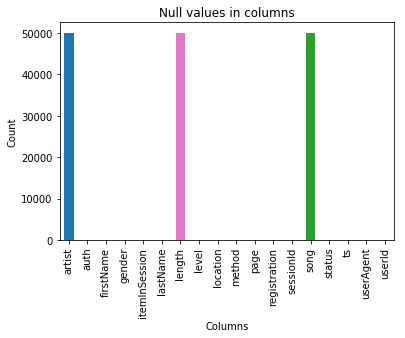

In [14]:
#Check the columns for null values
col_null={}
for i in dfSparkifyEvent.columns :
    col_null[i]=dfSparkifyEvent.where(col(i).isNull()).count()
col_null=pd.Series(col_null)
ax=col_null.plot(kind='bar')
ax.set_xlabel('Columns')
ax.set_ylabel('Count')
ax.set_title('Null values in columns')

* We can conclude from the above chart that the only remaining missing data corresponds to events that are not songs being played, such as logging in, adding songs to playlists etc. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
dfSparkifyEvent.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [16]:
#Create a more intuitive timestamp feature
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
dfSparkifyEvent = dfSparkifyEvent.withColumn("time", get_time(dfSparkifyEvent.ts))
dfSparkifyEvent = dfSparkifyEvent.withColumn("registrationTime", get_time(dfSparkifyEvent.registration))





In [17]:
#Show count values for "page" in the dataset
dfSparkifyEvent.groupBy("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [18]:
#Inspect users who cancelled

#Restrict to userIds where they were on the Cancellation Confirmation page
dfCancelled=dfSparkifyEvent.filter(dfSparkifyEvent.page=="Cancellation Confirmation")
dfCancelledUsers=dfCancelled.select("userId").dropDuplicates()
dfCancelled.take(5)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', time='2018-10-07 20:26:30', registrationTime='2018-08-30 10:04:26'),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32', time='2018-10-08 21:

In [19]:
#Restrict to customer journey columns
dfSparkifyEvent.where(dfSparkifyEvent.userId==125)\
            .select(["userId", "page", "level", "song", "sessionId","time"]).orderBy(desc("time")).show(30)
dfSparkifyEvent.where(dfSparkifyEvent.userId==51)\
            .select(["userId", "page", "level", "song", "sessionId","time"]).orderBy(desc("time")).show(30)
dfSparkifyEvent.where(dfSparkifyEvent.userId==54)\
            .select(["userId", "page", "level", "song", "sessionId","time"]).orderBy(desc("time")).show(30)



+------+--------------------+-----+--------------------+---------+-------------------+
|userId|                page|level|                song|sessionId|               time|
+------+--------------------+-----+--------------------+---------+-------------------+
|   125|              Cancel| free|                null|      174|2018-10-12 04:35:18|
|   125|Cancellation Conf...| free|                null|      174|2018-10-12 04:35:18|
|   125|         Roll Advert| free|                null|      174|2018-10-12 04:35:17|
|   125|            NextSong| free|                Kota|      174|2018-10-12 04:35:06|
|   125|            NextSong| free|     They're Red Hot|      174|2018-10-12 04:32:08|
|   125|            NextSong| free|Don't Leave Me Be...|      174|2018-10-12 04:28:35|
|   125|            NextSong| free|       Love You Down|      174|2018-10-12 04:22:04|
|   125|            NextSong| free|Leader Of Men (Al...|      174|2018-10-12 04:18:34|
|   125|            NextSong| free|       I

In [20]:
#View userIds where they were on the Cancellation Confirmation page but not the Cancel page
dfCancelledBoth = dfSparkifyEvent.where(dfSparkifyEvent.page.isin(["Cancellation Confirmation","Cancel"]))
dfCancelledBoth.filter(dfCancelledBoth.page=="Cancel").select("userId","page")\
                    .dropDuplicates().count()


52

We can conclude that the set of users that viewed "Cancellation Confirmation" is the same as those users that viewed "Cancel".

In [21]:
#Restrict to userIds where they were on the Submit Downgrade page
dfDowngraded=dfSparkifyEvent.filter(dfSparkifyEvent.page=="Submit Downgrade")
dfDowngradedUsers=dfDowngraded.select("userId").dropDuplicates()
dfDowngradedUsers.take(5)

[Row(userId='54'),
 Row(userId='11'),
 Row(userId='30'),
 Row(userId='59'),
 Row(userId='85')]

In [22]:
#Restrict to customer journey columns
dfSparkifyEvent.where(dfSparkifyEvent.userId==11)\
            .select(["userId", "page", "level", "song", "sessionId","time"]).orderBy(desc("time")).show(30)
dfSparkifyEvent.where(dfSparkifyEvent.userId==30)\
            .select(["userId", "page", "level", "song", "sessionId","time"]).orderBy(desc("time")).show(30)



+------+---------------+-----+--------------------+---------+-------------------+
|userId|           page|level|                song|sessionId|               time|
+------+---------------+-----+--------------------+---------+-------------------+
|    11|       NextSong| paid|Life As A Father ...|     2092|2018-11-27 09:08:22|
|    11|       NextSong| paid|Harmonic Necklace...|     2092|2018-11-27 09:07:09|
|    11|       NextSong| paid|        The Pioneers|     2092|2018-11-27 09:03:34|
|    11|       NextSong| paid|SegertÃÂ¥get (Da...|     2092|2018-11-27 08:58:29|
|    11|      Thumbs Up| paid|                null|     2092|2018-11-27 08:54:10|
|    11|       NextSong| paid|     We Were In Love|     2092|2018-11-27 08:54:09|
|    11|      Thumbs Up| paid|                null|     2092|2018-11-27 08:50:31|
|    11|       NextSong| paid|               Madre|     2092|2018-11-27 08:50:30|
|    11|       NextSong| paid|Orange TrÃÂ¤gt N...|     2092|2018-11-27 08:47:06|
|    11|       N

When customers view the "Cancellation Confirmation" page, it's one of their last interactions with Sparkify (along with "Cancel"). Therefore this should form the base for the definition of a churned customer. 

The same is not true of the "Submit Downgrade" page, which shows that the customer didn't churn. 

We will define a churned customer as one that views the "Cancellation Confirmation" page.

In [23]:
#Create Cancellation flag
churnFlag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churnFlag

dfSparkifyEvent = dfSparkifyEvent.withColumn("cancellationFlag", churnFlag("page"))

#View a record to see it's worked as expected
dfSparkifyEvent.where(dfSparkifyEvent.userId==125)\
                .select(["userId", "page", "level", "song", "sessionId","cancellationFlag"]).show(100)



+------+--------------------+-----+--------------------+---------+----------------+
|userId|                page|level|                song|sessionId|cancellationFlag|
+------+--------------------+-----+--------------------+---------+----------------+
|   125|            NextSong| free|    paranoid android|      174|               0|
|   125|            NextSong| free|Hypnotize(Album V...|      174|               0|
|   125|            NextSong| free|       I'm On My Way|      174|               0|
|   125|            NextSong| free|Leader Of Men (Al...|      174|               0|
|   125|            NextSong| free|       Love You Down|      174|               0|
|   125|            NextSong| free|Don't Leave Me Be...|      174|               0|
|   125|            NextSong| free|     They're Red Hot|      174|               0|
|   125|            NextSong| free|                Kota|      174|               0|
|   125|         Roll Advert| free|                null|      174|          

In [24]:
#Create Churn flag
windowval1 = Window.partitionBy("userId").orderBy(asc("time"))\
                .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
withChurn = dfSparkifyEvent.withColumn("churn", max("cancellationFlag").over(windowval1))

#View a record to see it's worked as expected
withChurn.where(withChurn.userId==125)\
        .select(["userId", "page", "level", "song", "sessionId","cancellationFlag","churn"]).show(100)



+------+--------------------+-----+--------------------+---------+----------------+-----+
|userId|                page|level|                song|sessionId|cancellationFlag|churn|
+------+--------------------+-----+--------------------+---------+----------------+-----+
|   125|            NextSong| free|    paranoid android|      174|               0|    1|
|   125|            NextSong| free|Hypnotize(Album V...|      174|               0|    1|
|   125|            NextSong| free|       I'm On My Way|      174|               0|    1|
|   125|            NextSong| free|Leader Of Men (Al...|      174|               0|    1|
|   125|            NextSong| free|       Love You Down|      174|               0|    1|
|   125|            NextSong| free|Don't Leave Me Be...|      174|               0|    1|
|   125|            NextSong| free|     They're Red Hot|      174|               0|    1|
|   125|            NextSong| free|                Kota|      174|               0|    1|
|   125|  

In [25]:
#View to see it's worked as expected
withChurn.select("userId","churn").dropDuplicates().show(10)


+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [26]:
cancelledCustCount = withChurn.filter(withChurn.churn ==1).select("userId").dropDuplicates().count()
notCancelledCustCount = withChurn.filter(withChurn.churn ==0).select("userId").dropDuplicates().count()

print("No. of customers that have cancelled: ", cancelledCustCount)
print("No. of customers that have not cancelled: ", notCancelledCustCount)


No. of customers that have cancelled:  52
No. of customers that have not cancelled:  173


#### Note: 

The dataset is imbalanced. This is important to note as it will affect the metrics we choose to assess model performance.

#### Gender by churn

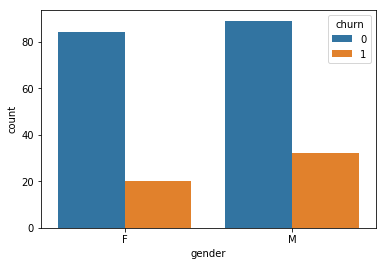

In [27]:
churnByGender = withChurn.select(["userId","gender","churn"]).dropDuplicates().toPandas()

ax = sns.countplot(x = "gender", hue = "churn", data = churnByGender)



It looks like men are more likely to churn than women.

#### Subscription level by churn

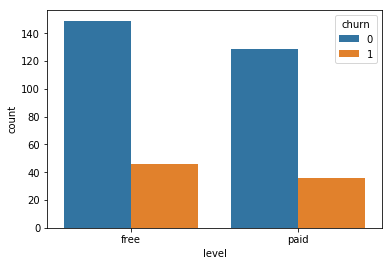

In [28]:
churnByLevel = withChurn.select(["userId","level","churn"]).dropDuplicates().toPandas()

ax = sns.countplot(x = "level", hue = "churn", data = churnByLevel)




Users that pay for their subscription are less likely to churn than those on the free membership.

#### Average number of page visits by churn

In [29]:
cancelledCustPages = withChurn.filter(withChurn.churn ==1).groupby("page").count()
cancelledCustPages = cancelledCustPages\
        .withColumn("avgPageVisitsChurned",cancelledCustPages["count"]/cancelledCustCount)

notCancelledCustPages = withChurn.filter(withChurn.churn ==0).groupby("page").count()
notCancelledCustPages = notCancelledCustPages\
        .withColumn("avgPageVisitsActive",notCancelledCustPages["count"]/notCancelledCustCount)

#Concatenate above tables
avgPageCountChurn=cancelledCustPages\
        .join(notCancelledCustPages,"page","outer").drop("count").toPandas().fillna(0)
avgPageCountChurn

,page,avgPageVisitsChurned,avgPageVisitsActive
0,Cancel,1.000000,0.000000
1,Submit Downgrade,0.173077,0.312139
2,Thumbs Down,9.538462,11.849711
3,Home,32.153846,48.612717
4,Downgrade,6.480769,9.930636
5,Roll Advert,18.596154,17.144509
6,Logout,10.634615,15.450867
7,Save Settings,1.115385,1.456647
8,Cancellation Confirmation,1.000000,0.000000
9,About,1.076923,2.537572


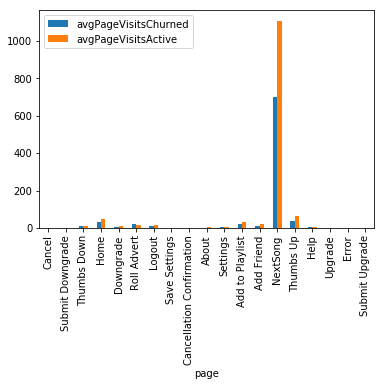

In [30]:
avgPageCountChurn.plot.bar("page")

In [31]:
#Dominated by "Next Song" so remove this to see what it looks like

removeNextSong = withChurn.filter(withChurn["page"] != "NextSong")

cancelledCustPages = removeNextSong.filter(withChurn.churn ==1).groupby("page").count()
cancelledCustPages = cancelledCustPages\
            .withColumn("avgPageVisitsChurned",cancelledCustPages["count"]/cancelledCustCount)

notCancelledCustPages = removeNextSong.filter(withChurn.churn ==0).groupby("page").count()
notCancelledCustPages = notCancelledCustPages\
            .withColumn("avgPageVisitsActive",notCancelledCustPages["count"]/notCancelledCustCount)

#Concatenate above tables
avgPageCountChurn=cancelledCustPages.join(notCancelledCustPages,"page","outer")\
                        .drop("count").toPandas().fillna(0)
avgPageCountChurn



,page,avgPageVisitsChurned,avgPageVisitsActive
0,Cancel,1.000000,0.000000
1,Submit Downgrade,0.173077,0.312139
2,Thumbs Down,9.538462,11.849711
3,Home,32.153846,48.612717
4,Downgrade,6.480769,9.930636
5,Roll Advert,18.596154,17.144509
6,Logout,10.634615,15.450867
7,Save Settings,1.115385,1.456647
8,Cancellation Confirmation,1.000000,0.000000
9,About,1.076923,2.537572


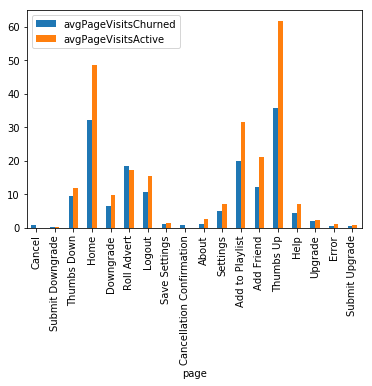

In [32]:
avgPageCountChurn.plot.bar("page")

The pages "Home", "Add Friend", "Add to Playlist", "Next Song","Thumbs Up" and "Logout" all have some differences in proportion between churned and active users. Features based on views of these pages would be good to input into the churn model.


#### Average number of songs played each session

In [33]:
songByChurn=withChurn.filter(withChurn.song.isNotNull()).groupby('churn').count()\
                    .withColumnRenamed("count","songCount").toPandas()

print(songByChurn)


sessionByChurn=withChurn.filter(withChurn.song.isNotNull())\
                    .select("userId","sessionId","churn").dropDuplicates()
sessionByChurn=sessionByChurn.groupby(["churn"]).count()\
            .withColumnRenamed("count","sessionCount").toPandas()


print(sessionByChurn)

#Merge above tables
SongsSessionChurn=songByChurn.merge(sessionByChurn,on="churn",how="inner")



SongsSessionChurn['songPerSession'] = SongsSessionChurn['songCount']/SongsSessionChurn['sessionCount']
SongsSessionChurn


   churn  songCount
0      1      36394
1      0     191714
   churn  sessionCount
0      1           519
1      0          2552


,churn,songCount,sessionCount,songPerSession
0,1,36394,519,70.123314
1,0,191714,2552,75.123041


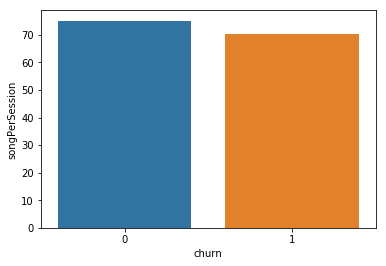

In [34]:
ax = sns.barplot(x = "churn", y = "songPerSession", data = SongsSessionChurn)


We can see that there's a difference between how many songs are being played on average in each session for a user that is still active, compared to a user that's churned. 

#### Number of days since registration

In [35]:
w1 = Window.partitionBy('userId')

In [36]:

#Number of days since registration
w1 = Window.partitionBy('userId')

#Create udf for calculating the difference in weeks of two timestamps
diffWeeks = udf(lambda x, y: (x-y)/604800000)

#Earliest and latest timestamp variables
dfTimeStamps=withChurn.withColumn('tsMin', min('ts').over(w1))
dfTimeStamps=withChurn.withColumn('tsMax', max('ts').over(w1))


#Weeks user is registered
weeksRegistered=dfTimeStamps.select("userId","tsMax","registration","churn").dropDuplicates()\
                    .withColumn("weeksRegistered", diffWeeks(col("tsMax"),col("registration")).cast("float"))



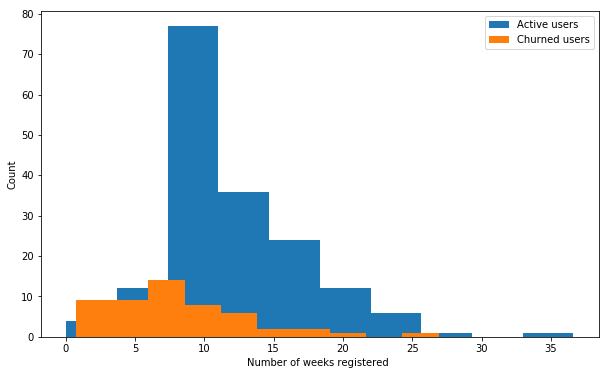

In [37]:
#Histogram of number of weeks registered by churn

weeksRegistered = weeksRegistered.select('churn','weeksRegistered').toPandas()

# plot results
plt.figure(figsize=(10,6))
plt.hist(weeksRegistered['weeksRegistered'][weeksRegistered['churn'] == 0], label='Active users')
plt.hist(weeksRegistered['weeksRegistered'][weeksRegistered['churn'] == 1], label='Churned users')
plt.legend(loc='upper right')
plt.xlabel('Number of weeks registered ')
plt.ylabel('Count')
plt.show()


We can see that users that are relatively newer on book are more likely to churn.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Having explored some of the trends of the dataset, we've got an idea of good features for a model predicting customer churn. 

The following customer level features will be defined:
* Number of days/weeks/fortnights since registration and latest activity
* Subscription level of the customer at their latest activity
* Total number of sessions
* Total number of interactions made
* Total length of time the customer has spent on the website
* Average number of interactions per session
* Average session length
* Average number of sessions per week
* Total number of songs played
* Average number of songs played per session
* Average number of songs played per week

* Average per session/average per week/total number "Home" page has been accessed
* Average per session/average per week/total number "Add Friend" page has been accessed
* Average per session/average per week/total number "Add to Playlist" page has been accessed
* Average per session/average per week/total number "Next Song" page has been accessed
* Average per session/average per week/total number "Thumbs Up" page has been accessed
* Average per session/average per week/total number "Logout" page has been accessed
* Total number of days/weeks/fortnights active
* Proportion of active days/weeks
* Total number of sessions in the first week before final activity
* Total number of interaction in the first week before final activity
* Total length of time on site in the first week before final activity
* Average number of interaction per session in the first week before final activity
* Average length per session in the first week before final activity
* Total number of sessions in the second week before final activity
* Total number of interaction in the second week before final activity
* Total length of time on site in the second week before final activity
* Average number of interaction in the second week before final activity
* Average length per session in the second week before final activity
* Total number of sessions in the third week before final activity
* Total number of interaction in the third week before final activity
* Total length of time on site in the third week before final activity
* Average number of interaction per session in the third week before final activity
* Average length per session up in the third week before final activity
* Total number of sessions in the fourth week before final activity
* Total number of interaction in the fourth week before final activity
* Total length of time on site in the fourth week before final activity
* Average number of interaction per session in the fourth week before final activity
* Average length per session in the fourth week before final activity
* Total number of days active in the first fortnight before final activity
* Total number of weeks active in the first fortnight before final activity
* Total number of fortnights active in the first fortnight before final activity
* Proportion of active days/weeks in the first fortnight before final activity 

* Total number of days active in the second fortnight before final activity
* Total number of weeks active in the second fortnight before final activity
* Total number of fortnights active in the second fortnight before final activity
* Proportion of active days/weeks in the second fortnight before final activity 
















In [38]:
# create partitions
w1 = Window.partitionBy('userId')
w2 = Window.partitionBy('userId', 'sessionId')
w3 = Window.partitionBy('userId', 'daysToLatest')
w4 = Window.partitionBy('userId', 'weeksToLatest')
w5 = Window.partitionBy('userId', 'fortnightsToLatest')
w6 = Window.partitionBy('userId', 'sessionId','weeksToLatest')

# create udfs
diffDays = udf(lambda x, y: (x-y)/86400000)
diffWeeks = udf(lambda x, y: (x-y)/604800000)
diffFortnights = udf(lambda x, y: (x-y)/(604800000*2))


In [39]:
dfBase=withChurn

#Earliest and latest timestamp variables
dfBase=dfBase.withColumn('tsMin', min('ts').over(w1))
dfBase=dfBase.withColumn('tsMax', max('ts').over(w1))

#Number of days/weeks from earliest interaction to the latest interaction
dfBase=dfBase.withColumn("daysMinToMax", diffDays(col("tsMax"),col("tsMin")))
dfBase=dfBase.withColumn("weeksMinToMax", diffWeeks(col("tsMax"),col("tsMin")))
dfBase=dfBase.withColumn("fortnightsMinToMax", diffFortnights(col("tsMax"),col("tsMin")))


#Days/Weeks user is registered
dfBase=dfBase.withColumn("daysRegistered", diffDays(col("tsMax"),col("registration")))
dfBase=dfBase.withColumn("weeksRegistered", diffWeeks(col("tsMax"),col("registration")))
#dfBase=dfBase.withColumn("fortnightsRegistered", diffFortnights(col("tsLatest"),col("registration")))

#Number of days/weeks from event to the latest interaction
dfBase=dfBase.withColumn("daysToLatest", floor(diffDays(col("tsMax"),col("ts"))))
dfBase=dfBase.withColumn("weeksToLatest", floor(diffWeeks(col("tsMax"),col("ts"))))
dfBase=dfBase.withColumn("fortnightsToLatest", floor(diffFortnights(col("tsMax"),col("ts"))))


In [40]:
#Start building the final dataset of features for modelling
dfFinal = dfBase.select("userId","gender","churn",'tsMin','tsMax',\
             'daysMinToMax','weeksMinToMax','fortnightsMinToMax',\
                'daysRegistered','weeksRegistered')\
            .dropDuplicates()


In [41]:
#Subscription level at latest interaction
dfLevel=dfBase.select("userId","level","ts","tsMax")\
        .where(col("ts")==col("tsMax"))\
        .withColumnRenamed("level","latestLevel")\
        .withColumnRenamed("userId","userId1")\
        .drop("ts","tsMax").dropDuplicates()

#Join to final dataset
dfFinal=dfFinal.join(dfLevel, dfFinal.userId==dfLevel.userId1, how="left")\
            .select(dfFinal["*"],dfLevel["latestLevel"])


dfFinal.take(1)


[Row(userId='100010', gender='F', churn=0, tsMin=1539003534000, tsMax=1542823952000, daysMinToMax='44.21780092592593', weeksMinToMax='6.316828703703703', fortnightsMinToMax='3.1584143518518517', daysRegistered='55.64365740740741', weeksRegistered='7.949093915343916', latestLevel='free')]

In [42]:
#Total number of sessions per user
#Total number interactions per user
#Total length of activity

dfSession = dfBase.select("userId", "sessionId", \
                          sum("length").over(w2).alias("lengthSessions"),\
                          count("userId").over(w2).alias("eventsSessions"))\
                    .dropDuplicates()

dfSession = dfSession.withColumn("totalSession", count("sessionId").over(w1))\
                     .withColumn("totalInteraction", sum("eventsSessions").over(w1))\
                     .withColumn("totalLength", sum("lengthSessions").over(w1))\
                     .withColumnRenamed("userId","userId2")\
                     .drop("sessionId","eventsSessions","lengthSessions").dropDuplicates()


#Join to final dataset and create the following features
#Avg interactions per session
#Avg length of session 
#Avg sessions per week
#Avg length of activity each week
dfFinal = dfFinal.join(dfSession, dfFinal.userId==dfSession.userId2, how="left")\
            .select(dfFinal["*"],\
             dfSession["totalSession"],dfSession["totalInteraction"],dfSession["totalLength"])\

dfFinal = dfFinal.withColumn("avgIntPerSession",dfFinal["totalInteraction"]/dfFinal["totalSession"])\
            .withColumn("avgSessionLength",dfFinal["totalLength"]/dfFinal["totalSession"])\
            .withColumn("avgSessionsPerWeek",dfFinal["totalSession"]/dfFinal["weeksMinToMax"])\
            .withColumn("avgSessionsPerWeek",dfFinal["totalLength"]/dfFinal["weeksMinToMax"])

dfFinal.take(1)



[Row(userId='100010', gender='F', churn=0, tsMin=1539003534000, tsMax=1542823952000, daysMinToMax='44.21780092592593', weeksMinToMax='6.316828703703703', fortnightsMinToMax='3.1584143518518517', daysRegistered='55.64365740740741', weeksRegistered='7.949093915343916', latestLevel='free', totalSession=7, totalInteraction=381, totalLength=66940.89735, avgIntPerSession=54.42857142857143, avgSessionLength=9562.985335714286, avgSessionsPerWeek=10597.231694877368)]

In [43]:
#Total songs played 
dfSong = dfBase.where(dfBase.song.isNotNull())\
                .select("userId", "sessionId", count("userId").over(w2).alias("songsSessions"))\
                .dropDuplicates()

dfSong = dfSong.withColumn("totalSession", count("sessionId").over(w1))\
                     .withColumn("totalSong", sum("songsSessions").over(w1))\
                     .withColumnRenamed("userId","userId3")\
                     .drop("sessionId","songsSessions").dropDuplicates()

#Join to final dataset and create the following features
#Avg number of songs played per session 
#Avg number of songs played per week
dfFinal=dfFinal.join(dfSong, dfFinal.userId==dfSong.userId3, how="left")\
               .select(dfFinal["*"], dfSong["totalSong"])\
               .na.fill(0)

dfFinal = dfFinal.withColumn("avgSongPerSession",dfFinal["totalSong"]/dfFinal["totalSession"])\
            .withColumn("avgSongPerWeek",dfFinal["totalSong"]/dfFinal["weeksMinToMax"])

dfFinal.show(1)


+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSession|   avgSongPerWeek|
+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+
|100010|     F|    0|1539003534000|1542823952000|44.21780092592593|6.316828703703703|3.1584143518518517|55.64

In [44]:
#Total times "Home" is visited  
dfHome = dfBase.where(dfBase.page == "Home")\
                .select("userId", count("userId").over(w1).alias("totalHome"))\
                .dropDuplicates()\
                .withColumnRenamed("userId","userId4")

#Join to final dataset and create the following features
#Avg number of "Home" visits played per session 
#Avg number of "Home" visits played per week
dfFinal=dfFinal.join(dfHome, dfFinal.userId==dfHome.userId4, how="left")\
            .select(dfFinal["*"],\
             dfHome["totalHome"]).na.fill(0)

dfFinal = dfFinal.withColumn("avgHomePerSession",dfFinal["totalHome"]/dfFinal["totalSession"])\
            .withColumn("avgHomePerWeek",dfFinal["totalHome"]/dfFinal["weeksMinToMax"])
            

dfFinal.show(1)

+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSession|   avgSongPerWeek|totalHome| avgHomePerSession|   avgHomePerWeek|
+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------

In [45]:
#Total times "Add Friend" is visited  
dfAddFriend = dfBase.where(dfBase.page == "Add Friend")\
                .select("userId", count("userId").over(w1).alias("totalAddFriend"))\
                .dropDuplicates()\
                .withColumnRenamed("userId","userId5")

#Join to final dataset and create the following features
#Avg number of "Add Friend" visits played per session 
#Avg number of "Add Friend" visits played per week
dfFinal=dfFinal.join(dfAddFriend, dfFinal.userId==dfAddFriend.userId5, how="left")\
            .select(dfFinal["*"],\
             dfAddFriend["totalAddFriend"]).na.fill(0)

dfFinal = dfFinal.withColumn("avgAddFriendPerSession",dfFinal["totalAddFriend"]/dfFinal["totalSession"])\
            .withColumn("avgAddFriendPerWeek",dfFinal["totalAddFriend"]/dfFinal["weeksMinToMax"])

dfFinal.show(1)



+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSession|   avgSongPerWeek|totalHome| avgHomePerSession|   avgHomePerWeek|totalAddFriend|avgAddFriendPerSession|avgAddFriendPerWeek|
+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+--

In [46]:
#Total times "Add to Playlist" is visited  
dfAddToPlaylist = dfBase.where(dfBase.page == "Add to Playlist")\
                .select("userId", count("userId").over(w1).alias("totalAddToPlaylist"))\
                .dropDuplicates()\
                .withColumnRenamed("userId","userId6")

#Join to final dataset and create the following features
#Avg number of "Add to Playlist" visits played per session 
#Avg number of "Add to Playlist" visits played per week

dfFinal=dfFinal.join(dfAddToPlaylist, dfFinal.userId==dfAddToPlaylist.userId6, how="left")\
            .select(dfFinal["*"],\
             dfAddToPlaylist["totalAddToPlaylist"]).na.fill(0)

dfFinal = dfFinal.withColumn("avgAddToPlaylistPerSession",dfFinal["totalAddToPlaylist"]/dfFinal["totalSession"])\
            .withColumn("avgAddToPlaylistPerWeek",dfFinal["totalAddToPlaylist"]/dfFinal["weeksMinToMax"])

dfFinal.show(1)




+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+------------------+--------------------------+-----------------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSession|   avgSongPerWeek|totalHome| avgHomePerSession|   avgHomePerWeek|totalAddFriend|avgAddFriendPerSession|avgAddFriendPerWeek|totalAddToPlaylist|avgAddToPlaylistPerSession|avgAddToPlaylistPerWeek|
+------+------+-----+-------------+-------------+-------

In [47]:
#Total times "NextSong" is visited  

dfNextSong = dfBase.where(dfBase.page == "NextSong")\
                .select("userId", count("userId").over(w1).alias("totalNextSong"))\
                .dropDuplicates()\
                .withColumnRenamed("userId","userId7")

#Join to final dataset and create the following features
#Avg number of "NextSong" visits played per session 
#Avg number of "NextSong" visits played per week
dfFinal=dfFinal.join(dfNextSong, dfFinal.userId==dfNextSong.userId7, how="left")\
            .select(dfFinal["*"],\
             dfNextSong["totalNextSong"]).na.fill(0)

dfFinal = dfFinal.withColumn("avgNextSongPerSession",dfFinal["totalNextSong"]/dfFinal["totalSession"])\
            .withColumn("avgNextSongPerWeek",dfFinal["totalNextSong"]/dfFinal["weeksMinToMax"])

dfFinal.show(1)




+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+------------------+--------------------------+-----------------------+-------------+---------------------+------------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSession|   avgSongPerWeek|totalHome| avgHomePerSession|   avgHomePerWeek|totalAddFriend|avgAddFriendPerSession|avgAddFriendPerWeek|totalAddToPlaylist|avgAddToPlaylistPerSession|avgAddToPlaylistPerWeek|to

In [48]:
#Total times "Thumbs Up" is visited  

dfThumbsUp = dfBase.where(dfBase.page == "Thumbs Up")\
                .select("userId", count("userId").over(w1).alias("totalThumbsUp"))\
                .dropDuplicates()\
                .withColumnRenamed("userId","userId8")

#Join to final dataset and create the following features
#Avg number of "Thumbs Up" visits played per session 
#Avg number of "Thumbs Up" visits played per week

dfFinal=dfFinal.join(dfThumbsUp, dfFinal.userId==dfThumbsUp.userId8, how="left")\
            .select(dfFinal["*"],\
             dfThumbsUp["totalThumbsUp"]).na.fill(0)

dfFinal = dfFinal.withColumn("avgThumbsUpPerSession",dfFinal["totalThumbsUp"]/dfFinal["totalSession"])\
            .withColumn("avgThumbsUpPerWeek",dfFinal["totalThumbsUp"]/dfFinal["weeksMinToMax"])

dfFinal.show(1)



+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+------------------+--------------------------+-----------------------+-------------+---------------------+------------------+-------------+---------------------+------------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSession|   avgSongPerWeek|totalHome| avgHomePerSession|   avgHomePerWeek|totalAddFriend|avgAddFriendPerSession|avgAddFriendPerWeek|totalAddToPlaylis

In [49]:
#Total times "Logout" is visited  

dfLogout = dfBase.where(dfBase.page == "Logout")\
                .select("userId", count("userId").over(w1).alias("totalLogout"))\
                .dropDuplicates()\
                .withColumnRenamed("userId","userId9")

#Join to final dataset and create the following features
#Avg number of "Thumbs Up" visits played per session 
#Avg number of "Thumbs Up" visits played per week

dfFinal=dfFinal.join(dfLogout, dfFinal.userId==dfLogout.userId9, how="left")\
            .select(dfFinal["*"],\
             dfLogout["totalLogout"]).na.fill(0)

dfFinal = dfFinal.withColumn("avgLogoutPerSession",dfFinal["totalLogout"]/dfFinal["totalSession"])\
            .withColumn("avgLogoutPerWeek",dfFinal["totalLogout"]/dfFinal["weeksMinToMax"])

dfFinal.show(1)

+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+------------------+--------------------------+-----------------------+-------------+---------------------+------------------+-------------+---------------------+------------------+-----------+-------------------+------------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSession|   avgSongPerWeek|totalHome| avgHomePerSession|   avgHomePerWeek|totalAddFriend|avgAddFri

In [50]:
#Total number of active days per user
#Total number of active weeks per user
#Total number of active fortnights per user

dfActive = dfBase.select("userId","daysToLatest","weeksToLatest","fortnightsToLatest",\
                          count("userId").over(w3).alias("eventsActiveDays"))\
                 .dropDuplicates()

dfActive = dfActive.withColumn("totalDaysActive", count("daysToLatest").over(w1))\
                   .drop("daysToLatest","eventsActiveDays").dropDuplicates()

dfActive = dfActive.select("userId","totalDaysActive", "weeksToLatest","fortnightsToLatest", \
                          count("userId").over(w4).alias("eventsActiveWeeks"))\
                   .dropDuplicates()
dfActive = dfActive.withColumn("totalWeeksActive", count("weeksToLatest").over(w1))\
                   .drop("weeksToLatest","eventsActiveWeeks").dropDuplicates()

dfActive = dfActive.select("userId","totalDaysActive", "totalWeeksActive","fortnightsToLatest", \
                          count("userId").over(w5).alias("eventsActiveFortnights"))\
                 .dropDuplicates()
dfActive = dfActive.withColumn("totalFortnightsActive", count("fortnightsToLatest").over(w1))\
                   .drop("fortnightsToLatest","eventsActiveFortnights").dropDuplicates()\
                   .withColumnRenamed("userId","userId10")

#Join to final dataset and create the following features
#Proportion of Active Days to Inactive Days
#Proportion of Active Weeks to Inactive Weeks
#Proportion of Active Fortnights to Inactive Fortnights
dfFinal=dfFinal.join(dfActive, dfFinal.userId==dfActive.userId10, how="left")\
            .select(dfFinal["*"],\
             dfActive["totalDaysActive"],dfActive["totalWeeksActive"],dfActive["totalFortnightsActive"])

dfFinal = dfFinal.withColumn("ActiveDaysRatio",dfFinal["totalDaysActive"]/dfFinal["daysMinToMax"])\
            .withColumn("ActiveWeeksRatio",dfFinal["totalWeeksActive"]/dfFinal["weeksMinToMax"])\
            .withColumn("ActiveWeeksRatio",dfFinal["totalFortnightsActive"]/dfFinal["fortnightsMinToMax"])

dfFinal.show(1)





+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+------------------+--------------------------+-----------------------+-------------+---------------------+------------------+-------------+---------------------+------------------+-----------+-------------------+------------------+---------------+----------------+---------------------+-------------------+------------------+
|userId|gender|churn|        tsMin|        tsMax|     daysMinToMax|    weeksMinToMax|fortnightsMinToMax|   daysRegistered|  weeksRegistered|latestLevel|totalSession|totalInteraction|totalLength| avgIntPerSession| avgSessionLength|avgSessionsPerWeek|totalSong| avgSongPerSes

In [51]:
#Features specific to the week prior to the final interaction
#Total number of sessions 
#Total number interactions per 
#Total length per session


dfWeek0ToEnd=dfBase.where(dfBase.weeksToLatest==0).select("userId", "sessionId", \
                          sum("length").over(w2).alias("lengthSessionsWk0"),\
                          count("userId").over(w2).alias("eventsSessionsWk0"))\
                    .dropDuplicates()

dfWeek0ToEnd = dfWeek0ToEnd.withColumn("totalSessionWk0", count("sessionId").over(w1))\
                     .withColumn("totalInteractionWk0", sum("eventsSessionsWk0").over(w1))\
                     .withColumn("totalLengthWk0", sum("lengthSessionsWk0").over(w1))\
                     .withColumnRenamed("userId","userIdWk0")\
                     .drop("sessionId","eventsSessionsWk0","lengthSessionsWk0").dropDuplicates()

#Join to final dataset and create the following features
#Avg interactions per session
#Avg length of session 
dfFinal=dfFinal.join(dfWeek0ToEnd, dfFinal.userId==dfWeek0ToEnd.userIdWk0, how="left")\
            .select(dfFinal["*"],\
             dfWeek0ToEnd["totalSessionWk0"],dfWeek0ToEnd["totalInteractionWk0"],dfWeek0ToEnd["totalLengthWk0"])\
            .na.fill(0)


dfFinal = dfFinal.withColumn("avgIntPerSessionWk0",dfFinal["totalInteractionWk0"]/dfFinal["totalSessionWk0"])\
            .withColumn("avgSessionLengthWk0",dfFinal["totalLengthWk0"]/dfFinal["totalSessionWk0"])\

dfFinal.take(1)

[Row(userId='100010', gender='F', churn=0, tsMin=1539003534000, tsMax=1542823952000, daysMinToMax='44.21780092592593', weeksMinToMax='6.316828703703703', fortnightsMinToMax='3.1584143518518517', daysRegistered='55.64365740740741', weeksRegistered='7.949093915343916', latestLevel='free', totalSession=7, totalInteraction=381, totalLength=66940.89735, avgIntPerSession=54.42857142857143, avgSessionLength=9562.985335714286, avgSessionsPerWeek=10597.231694877368, totalSong=275, avgSongPerSession=39.285714285714285, avgSongPerWeek=43.53450329257165, totalHome=11, avgHomePerSession=1.5714285714285714, avgHomePerWeek=1.741380131702866, totalAddFriend=4, avgAddFriendPerSession=0.5714285714285714, avgAddFriendPerWeek=0.6332291388010423, totalAddToPlaylist=7, avgAddToPlaylistPerSession=1.0, avgAddToPlaylistPerWeek=1.1081509929018238, totalNextSong=275, avgNextSongPerSession=39.285714285714285, avgNextSongPerWeek=43.53450329257165, totalThumbsUp=17, avgThumbsUpPerSession=2.4285714285714284, avgThum

In [52]:
#Features specific to the second week prior to the final interaction
#Total number of sessions in each of the final four weeks of user activity
#Total number interactions per user
#Total length per session

dfWeek1ToEnd=dfBase.where(dfBase.weeksToLatest==1).select("userId", "sessionId", \
                          sum("length").over(w2).alias("lengthSessionsWk1"),\
                          count("userId").over(w2).alias("eventsSessionsWk1"))\
                    .dropDuplicates()

dfWeek1ToEnd = dfWeek1ToEnd.withColumn("totalSessionWk1", count("sessionId").over(w1))\
                     .withColumn("totalInteractionWk1", sum("eventsSessionsWk1").over(w1))\
                     .withColumn("totalLengthWk1", sum("lengthSessionsWk1").over(w1))\
                     .withColumnRenamed("userId","userIdWk1")\
                     .drop("sessionId","eventsSessionsWk1","lengthSessionsWk1").dropDuplicates()

#Join to final dataset and create the following features
#Avg interactions per session
#Avg length of session 
dfFinal=dfFinal.join(dfWeek1ToEnd, dfFinal.userId==dfWeek1ToEnd.userIdWk1, how="left")\
            .select(dfFinal["*"],\
             dfWeek1ToEnd["totalSessionWk1"],dfWeek1ToEnd["totalInteractionWk1"],dfWeek1ToEnd["totalLengthWk1"])\
            .na.fill(0)


dfFinal = dfFinal.withColumn("avgIntPerSessionWk1",dfFinal["totalInteractionWk1"]/dfFinal["totalSessionWk1"])\
            .withColumn("avgSessionLengthWk1",dfFinal["totalLengthWk1"]/dfFinal["totalSessionWk1"])\

dfFinal.take(1)

[Row(userId='100010', gender='F', churn=0, tsMin=1539003534000, tsMax=1542823952000, daysMinToMax='44.21780092592593', weeksMinToMax='6.316828703703703', fortnightsMinToMax='3.1584143518518517', daysRegistered='55.64365740740741', weeksRegistered='7.949093915343916', latestLevel='free', totalSession=7, totalInteraction=381, totalLength=66940.89735, avgIntPerSession=54.42857142857143, avgSessionLength=9562.985335714286, avgSessionsPerWeek=10597.231694877368, totalSong=275, avgSongPerSession=39.285714285714285, avgSongPerWeek=43.53450329257165, totalHome=11, avgHomePerSession=1.5714285714285714, avgHomePerWeek=1.741380131702866, totalAddFriend=4, avgAddFriendPerSession=0.5714285714285714, avgAddFriendPerWeek=0.6332291388010423, totalAddToPlaylist=7, avgAddToPlaylistPerSession=1.0, avgAddToPlaylistPerWeek=1.1081509929018238, totalNextSong=275, avgNextSongPerSession=39.285714285714285, avgNextSongPerWeek=43.53450329257165, totalThumbsUp=17, avgThumbsUpPerSession=2.4285714285714284, avgThum

In [53]:
#Features specific to the third week prior to the final interaction
#Total number of sessions
#Total number interactions per user
#Total length per session
dfWeek2ToEnd=dfBase.where(dfBase.weeksToLatest==2).select("userId", "sessionId", \
                          sum("length").over(w2).alias("lengthSessionsWk2"),\
                          count("userId").over(w2).alias("eventsSessionsWk2"))\
                    .dropDuplicates()

dfWeek2ToEnd = dfWeek2ToEnd.withColumn("totalSessionWk2", count("sessionId").over(w1))\
                     .withColumn("totalInteractionWk2", sum("eventsSessionsWk2").over(w1))\
                     .withColumn("totalLengthWk2", sum("lengthSessionsWk2").over(w1))\
                     .withColumnRenamed("userId","userIdWk2")\
                     .drop("sessionId","eventsSessionsWk2","lengthSessionsWk2").dropDuplicates()


#Join to final dataset and create the following features
#Avg interactions per session
#Avg length of session
dfFinal=dfFinal.join(dfWeek2ToEnd, dfFinal.userId==dfWeek2ToEnd.userIdWk2, how="left")\
            .select(dfFinal["*"],\
             dfWeek2ToEnd["totalSessionWk2"],dfWeek2ToEnd["totalInteractionWk2"],dfWeek2ToEnd["totalLengthWk2"])\
            .na.fill(0)

dfFinal = dfFinal.withColumn("avgIntPerSessionWk2",dfFinal["totalInteractionWk2"]/dfFinal["totalSessionWk2"])\
            .withColumn("avgSessionLengthWk2",dfFinal["totalLengthWk2"]/dfFinal["totalSessionWk2"])\

dfFinal.take(1)

[Row(userId='100010', gender='F', churn=0, tsMin=1539003534000, tsMax=1542823952000, daysMinToMax='44.21780092592593', weeksMinToMax='6.316828703703703', fortnightsMinToMax='3.1584143518518517', daysRegistered='55.64365740740741', weeksRegistered='7.949093915343916', latestLevel='free', totalSession=7, totalInteraction=381, totalLength=66940.89735, avgIntPerSession=54.42857142857143, avgSessionLength=9562.985335714286, avgSessionsPerWeek=10597.231694877368, totalSong=275, avgSongPerSession=39.285714285714285, avgSongPerWeek=43.53450329257165, totalHome=11, avgHomePerSession=1.5714285714285714, avgHomePerWeek=1.741380131702866, totalAddFriend=4, avgAddFriendPerSession=0.5714285714285714, avgAddFriendPerWeek=0.6332291388010423, totalAddToPlaylist=7, avgAddToPlaylistPerSession=1.0, avgAddToPlaylistPerWeek=1.1081509929018238, totalNextSong=275, avgNextSongPerSession=39.285714285714285, avgNextSongPerWeek=43.53450329257165, totalThumbsUp=17, avgThumbsUpPerSession=2.4285714285714284, avgThum

In [54]:
#Features specific to the fourth week prior to the final interaction
#Total number of sessions 
#Total number interactions per user
#Total length per session
dfWeek3ToEnd=dfBase.where(dfBase.weeksToLatest==3).select("userId", "sessionId", \
                          sum("length").over(w2).alias("lengthSessionsWk3"),\
                          count("userId").over(w2).alias("eventsSessionsWk3"))\
                    .dropDuplicates()


dfWeek3ToEnd = dfWeek3ToEnd.withColumn("totalSessionWk3", count("sessionId").over(w1))\
                     .withColumn("totalInteractionWk3", sum("eventsSessionsWk3").over(w1))\
                     .withColumn("totalLengthWk3", sum("lengthSessionsWk3").over(w1))\
                     .withColumnRenamed("userId","userIdWk3")\
                     .drop("sessionId","eventsSessionsWk3","lengthSessionsWk3").dropDuplicates()

#Join to final dataset and create the following features
#Avg interactions per session
#Avg length of session
dfFinal=dfFinal.join(dfWeek3ToEnd, dfFinal.userId==dfWeek3ToEnd.userIdWk3, how="left")\
            .select(dfFinal["*"],\
             dfWeek3ToEnd["totalSessionWk3"],dfWeek3ToEnd["totalInteractionWk3"],dfWeek3ToEnd["totalLengthWk3"])\
            .na.fill(0)

dfFinal = dfFinal.withColumn("avgIntPerSessionWk3",dfFinal["totalInteractionWk3"]/dfFinal["totalSessionWk3"])\
            .withColumn("avgSessionLengthWk3",dfFinal["totalLengthWk3"]/dfFinal["totalSessionWk3"])\

dfFinal.take(1)



[Row(userId='100010', gender='F', churn=0, tsMin=1539003534000, tsMax=1542823952000, daysMinToMax='44.21780092592593', weeksMinToMax='6.316828703703703', fortnightsMinToMax='3.1584143518518517', daysRegistered='55.64365740740741', weeksRegistered='7.949093915343916', latestLevel='free', totalSession=7, totalInteraction=381, totalLength=66940.89735, avgIntPerSession=54.42857142857143, avgSessionLength=9562.985335714286, avgSessionsPerWeek=10597.231694877368, totalSong=275, avgSongPerSession=39.285714285714285, avgSongPerWeek=43.53450329257165, totalHome=11, avgHomePerSession=1.5714285714285714, avgHomePerWeek=1.741380131702866, totalAddFriend=4, avgAddFriendPerSession=0.5714285714285714, avgAddFriendPerWeek=0.6332291388010423, totalAddToPlaylist=7, avgAddToPlaylistPerSession=1.0, avgAddToPlaylistPerWeek=1.1081509929018238, totalNextSong=275, avgNextSongPerSession=39.285714285714285, avgNextSongPerWeek=43.53450329257165, totalThumbsUp=17, avgThumbsUpPerSession=2.4285714285714284, avgThum

In [55]:
#Features specific to the fortnight prior to the final interaction

#Total number of active days per user
#Total number interactions per user
#Total length per session


dfActiveFN0 = dfBase.where(dfBase.fortnightsToLatest==0)\
                 .select("userId","daysToLatest","weeksToLatest","fortnightsToLatest",\
                          count("userId").over(w3).alias("eventsActiveDays"))\
                 .dropDuplicates()

dfActiveFN0 = dfActiveFN0.withColumn("totalDaysActiveFN0", count("daysToLatest").over(w1))\
                   .drop("daysToLatest","eventsActiveDays").dropDuplicates()

dfActiveFN0 = dfActiveFN0.select("userId","totalDaysActiveFN0", "weeksToLatest","fortnightsToLatest", \
                          count("userId").over(w4).alias("eventsActiveWeeks"))\
                   .dropDuplicates()
dfActiveFN0 = dfActiveFN0.withColumn("totalWeeksActiveFN0", count("weeksToLatest").over(w1))\
                   .drop("weeksToLatest","eventsActiveWeeks").dropDuplicates()

dfActiveFN0 = dfActiveFN0.select("userId","totalDaysActiveFN0", "totalWeeksActiveFN0","fortnightsToLatest", \
                          count("userId").over(w5).alias("eventsActiveFortnights"))\
                 .dropDuplicates()
dfActiveFN0 = dfActiveFN0.withColumn("totalFortnightsActiveFN0", count("fortnightsToLatest").over(w1))\
                   .drop("fortnightsToLatest","eventsActiveFortnights").dropDuplicates()\
                   .withColumnRenamed("userId","userIdFN0")


#Join to final dataset and create the following features
#Proportion of Active Days to Inactive Days
#Proportion of Active Weeks to Inactive Weeks
dfFinal=dfFinal.join(dfActiveFN0, dfFinal.userId==dfActiveFN0.userIdFN0, how="left")\
            .select(dfFinal["*"],\
             dfActiveFN0["totalDaysActiveFN0"],dfActiveFN0["totalWeeksActiveFN0"],\
                    dfActiveFN0["totalFortnightsActiveFN0"])\
            .na.fill(0)

dfFinal = dfFinal.withColumn("ActiveDaysRatioFN0",dfFinal["totalDaysActiveFN0"]/14)\
            .withColumn("ActiveWeeksRatioFN0",dfFinal["totalWeeksActiveFN0"]/2)\

dfFinal.show(1)



+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+------------------+--------------------------+-----------------------+-------------+---------------------+------------------+-------------+---------------------+------------------+-----------+-------------------+------------------+---------------+----------------+---------------------+-------------------+------------------+---------------+-------------------+-----------------+-------------------+-------------------+---------------+-------------------+--------------+-------------------+-------------------+---------------+-------------------+--------------+-------------------+------------------

In [56]:
#Features specific to the penultimate fortnight prior to the final interaction
#Total number of active days per user
#Total number of active weeks per user
#Total number of active fortnights per user
dfActiveFN1 = dfBase.where(dfBase.fortnightsToLatest==1)\
                 .select("userId","daysToLatest","weeksToLatest","fortnightsToLatest",\
                          count("userId").over(w3).alias("eventsActiveDays"))\
                 .dropDuplicates()

dfActiveFN1 = dfActiveFN1.withColumn("totalDaysActiveFN1", count("daysToLatest").over(w1))\
                   .drop("daysToLatest","eventsActiveDays").dropDuplicates()

dfActiveFN1 = dfActiveFN1.select("userId","totalDaysActiveFN1", "weeksToLatest","fortnightsToLatest", \
                          count("userId").over(w4).alias("eventsActiveWeeks"))\
                   .dropDuplicates()
dfActiveFN1 = dfActiveFN1.withColumn("totalWeeksActiveFN1", count("weeksToLatest").over(w1))\
                   .drop("weeksToLatest","eventsActiveWeeks").dropDuplicates()

dfActiveFN1 = dfActiveFN1.select("userId","totalDaysActiveFN1", "totalWeeksActiveFN1","fortnightsToLatest", \
                          count("userId").over(w5).alias("eventsActiveFortnights"))\
                 .dropDuplicates()
dfActiveFN1 = dfActiveFN1.withColumn("totalFortnightsActiveFN1", count("fortnightsToLatest").over(w1))\
                   .drop("fortnightsToLatest","eventsActiveFortnights").dropDuplicates()\
                   .withColumnRenamed("userId","userIdFN1")


#Join to final dataset and create the following features
#Proportion of Active Days to Inactive Days
#Proportion of Active Weeks to Inactive Weeks
#Proportion of Active Fortnights to Inactive Fortnights
dfFinal=dfFinal.join(dfActiveFN1, dfFinal.userId==dfActiveFN1.userIdFN1, how="left")\
            .select(dfFinal["*"],\
             dfActiveFN1["totalDaysActiveFN1"],dfActiveFN1["totalWeeksActiveFN1"],\
                    dfActiveFN1["totalFortnightsActiveFN1"])\
            .na.fill(0)

dfFinal = dfFinal.withColumn("ActiveDaysRatioFN1",dfFinal["totalDaysActiveFN1"]/14)\
            .withColumn("ActiveWeeksRatioFN1",dfFinal["totalWeeksActiveFN1"]/2)\

dfFinal.show(1)






+------+------+-----+-------------+-------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+------------+----------------+-----------+-----------------+-----------------+------------------+---------+------------------+-----------------+---------+------------------+-----------------+--------------+----------------------+-------------------+------------------+--------------------------+-----------------------+-------------+---------------------+------------------+-------------+---------------------+------------------+-----------+-------------------+------------------+---------------+----------------+---------------------+-------------------+------------------+---------------+-------------------+-----------------+-------------------+-------------------+---------------+-------------------+--------------+-------------------+-------------------+---------------+-------------------+--------------+-------------------+------------------

In [57]:
#Convert "gender" and "latestLevel" into binary variables
dfFinal = dfFinal.withColumn("gender", when(dfFinal.gender == "F", 1).otherwise(0))
dfFinal = dfFinal.withColumn("latestLevel", when(dfFinal.latestLevel == "paid", 1).otherwise(0))

dfFinal.take(1)


[Row(userId='100010', gender=1, churn=0, tsMin=1539003534000, tsMax=1542823952000, daysMinToMax='44.21780092592593', weeksMinToMax='6.316828703703703', fortnightsMinToMax='3.1584143518518517', daysRegistered='55.64365740740741', weeksRegistered='7.949093915343916', latestLevel=0, totalSession=7, totalInteraction=381, totalLength=66940.89735, avgIntPerSession=54.42857142857143, avgSessionLength=9562.985335714286, avgSessionsPerWeek=10597.231694877368, totalSong=275, avgSongPerSession=39.285714285714285, avgSongPerWeek=43.53450329257165, totalHome=11, avgHomePerSession=1.5714285714285714, avgHomePerWeek=1.741380131702866, totalAddFriend=4, avgAddFriendPerSession=0.5714285714285714, avgAddFriendPerWeek=0.6332291388010423, totalAddToPlaylist=7, avgAddToPlaylistPerSession=1.0, avgAddToPlaylistPerWeek=1.1081509929018238, totalNextSong=275, avgNextSongPerSession=39.285714285714285, avgNextSongPerWeek=43.53450329257165, totalThumbsUp=17, avgThumbsUpPerSession=2.4285714285714284, avgThumbsUpPer

In [58]:
#Drop unnecessary columns
dfFinal = dfFinal.drop("tsMin","tsMax","daysMinToMax","weeksMinToMax","fortnightsMinToMax")\
                        .dropDuplicates()

dfFinal.columns

['userId',
 'gender',
 'churn',
 'daysRegistered',
 'weeksRegistered',
 'latestLevel',
 'totalSession',
 'totalInteraction',
 'totalLength',
 'avgIntPerSession',
 'avgSessionLength',
 'avgSessionsPerWeek',
 'totalSong',
 'avgSongPerSession',
 'avgSongPerWeek',
 'totalHome',
 'avgHomePerSession',
 'avgHomePerWeek',
 'totalAddFriend',
 'avgAddFriendPerSession',
 'avgAddFriendPerWeek',
 'totalAddToPlaylist',
 'avgAddToPlaylistPerSession',
 'avgAddToPlaylistPerWeek',
 'totalNextSong',
 'avgNextSongPerSession',
 'avgNextSongPerWeek',
 'totalThumbsUp',
 'avgThumbsUpPerSession',
 'avgThumbsUpPerWeek',
 'totalLogout',
 'avgLogoutPerSession',
 'avgLogoutPerWeek',
 'totalDaysActive',
 'totalWeeksActive',
 'totalFortnightsActive',
 'ActiveDaysRatio',
 'ActiveWeeksRatio',
 'totalSessionWk0',
 'totalInteractionWk0',
 'totalLengthWk0',
 'avgIntPerSessionWk0',
 'avgSessionLengthWk0',
 'totalSessionWk1',
 'totalInteractionWk1',
 'totalLengthWk1',
 'avgIntPerSessionWk1',
 'avgSessionLengthWk1',
 'total

In [59]:
#Check that there are still the correct number of userIds in the dataset (225)
print(dfFinal.count())

225


In [60]:
dfFinal.cache()

DataFrame[userId: string, gender: int, churn: int, daysRegistered: string, weeksRegistered: string, latestLevel: int, totalSession: bigint, totalInteraction: bigint, totalLength: double, avgIntPerSession: double, avgSessionLength: double, avgSessionsPerWeek: double, totalSong: bigint, avgSongPerSession: double, avgSongPerWeek: double, totalHome: bigint, avgHomePerSession: double, avgHomePerWeek: double, totalAddFriend: bigint, avgAddFriendPerSession: double, avgAddFriendPerWeek: double, totalAddToPlaylist: bigint, avgAddToPlaylistPerSession: double, avgAddToPlaylistPerWeek: double, totalNextSong: bigint, avgNextSongPerSession: double, avgNextSongPerWeek: double, totalThumbsUp: bigint, avgThumbsUpPerSession: double, avgThumbsUpPerWeek: double, totalLogout: bigint, avgLogoutPerSession: double, avgLogoutPerWeek: double, totalDaysActive: bigint, totalWeeksActive: bigint, totalFortnightsActive: bigint, ActiveDaysRatio: double, ActiveWeeksRatio: double, totalSessionWk0: bigint, totalInteract

In [61]:
#Check for the number of missings in the dataset
col_null={}
for i in dfFinal.columns :
    col_null[i]=dfFinal.where(col(i).isNull()).count()
col_null=pd.Series(col_null)
col_null.value_counts()


0    68
dtype: int64

In [62]:
dfFinal.printSchema()


root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- churn: integer (nullable = true)
 |-- daysRegistered: string (nullable = true)
 |-- weeksRegistered: string (nullable = true)
 |-- latestLevel: integer (nullable = false)
 |-- totalSession: long (nullable = true)
 |-- totalInteraction: long (nullable = true)
 |-- totalLength: double (nullable = false)
 |-- avgIntPerSession: double (nullable = false)
 |-- avgSessionLength: double (nullable = false)
 |-- avgSessionsPerWeek: double (nullable = false)
 |-- totalSong: long (nullable = true)
 |-- avgSongPerSession: double (nullable = false)
 |-- avgSongPerWeek: double (nullable = false)
 |-- totalHome: long (nullable = true)
 |-- avgHomePerSession: double (nullable = false)
 |-- avgHomePerWeek: double (nullable = false)
 |-- totalAddFriend: long (nullable = true)
 |-- avgAddFriendPerSession: double (nullable = false)
 |-- avgAddFriendPerWeek: double (nullable = false)
 |-- totalAddToPlaylist: long (nullab

In [63]:
#Find current direct
current_path = os.getcwd()
current_path

'/home/workspace'

'/home/workspace/dfFinal.csv'

In [65]:
#Save dataset as csv

dfFinal.toPandas().to_csv( current_path+'/dfFinal.csv', index = False)

## Please progress to Sparkify-model build.ipynb for model development